In [1]:
import pandas as pd
import numpy as np

installs= pd.read_csv('datos/installs.csv.gzip', compression = 'gzip')
installs.head()

,created,application_id,ref_type,ref_hash,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,trans_id,ip_address,device_language
0,2019-03-13 01:43:33.445,0,1891515180541284343,8464844987297247076,NaN,False,False,6333597102633388268,3.083059e+17,4.445252e+18,NaN,NaN,NaN,NaN,NaN,NaN,5529284367937637301,NaN
1,2019-03-13 04:58:35.078,0,1891515180541284343,3250564871270161533,NaN,False,False,6333597102633388268,3.083059e+17,4.445252e+18,NaN,NaN,NaN,NaN,NaN,NaN,6098022721363533304,NaN
2,2019-03-13 04:20:57.666,0,1891515180541284343,7953318831018100268,NaN,False,True,6333597102633388268,5.137992e+17,6.026543e+18,HasOffers Mobile AppTracking v1.0,NaN,0bfa9b4c-e07a-4522-b32d-138e3165ac98,Open,NaN,NaN,4636407223847323867,3.301378e+18
3,2019-03-13 04:20:57.698,0,1891515180541284343,7953318831018100268,NaN,False,False,6333597102633388268,5.137992e+17,6.026543e+18,NaN,NaN,NaN,NaN,NaN,NaN,4636407223847323867,NaN
4,2019-03-10 22:24:56.684,0,1891515180541284343,8355110941557237501,NaN,False,True,6333597102633388268,1.083369e+18,7.876612e+18,HasOffers Mobile AppTracking v1.0,NaN,8f235a8c-41bf-4399-b33d-c41577c949b0,Open,NaN,NaN,685400811232710215,3.301378e+18


In [2]:
installs.count()

created               3412
application_id        3412
ref_type              3412
ref_hash              3412
click_hash               0
attributed            3412
implicit              3412
device_countrycode    3412
device_brand          1047
device_model          3411
session_user_agent    3364
user_agent            1729
event_uuid             865
kind                   865
wifi                  1729
trans_id                 6
ip_address            3412
device_language       3378
dtype: int64

In [3]:
installs['ref_hash'].nunique()

3008

Son casi todos los usuarios distintos... Evidentemente nadie instala mas de una aplicacion

In [4]:
installs['attributed'].sum()

0

No hay ninguna instalacion atribuida a Jampp

## Afecta el wifi a la cantidad de installs?

In [5]:
wifi = installs['wifi'].dropna()
wifi.describe()

count     1729
unique       2
top       True
freq      1377
Name: wifi, dtype: object

In [6]:
1377*100/1729

79.64141122035859

El ~80% de la instalaciones se realizan estando conectados a wifi

## En que horarios sucede la mayor cantidad de instalaciones?

In [7]:
installs['created'] = pd.to_datetime(installs['created'])
installs['hour'] = installs['created'].dt.hour


Text(0, 0.5, 'Cantidad')

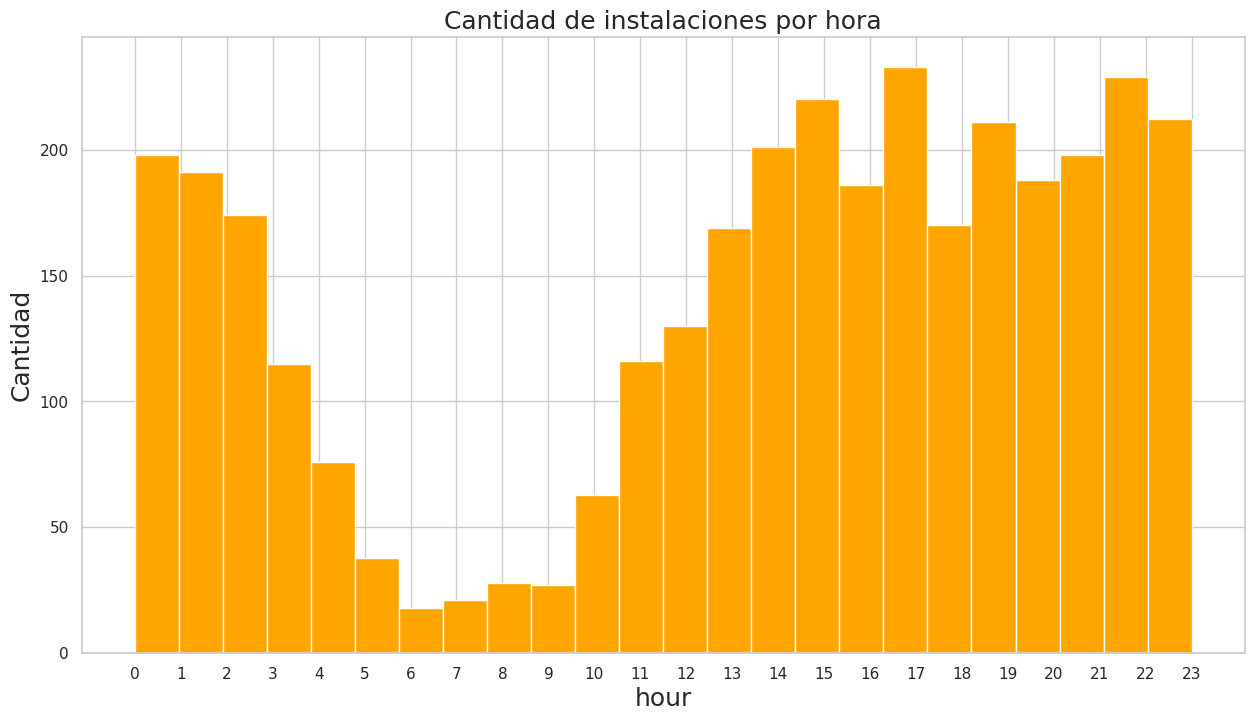

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

grafico_hora = installs['hour'].plot.hist(bins = 24, color = 'orange', figsize = (15,8))
grafico_hora.set_title('Cantidad de instalaciones por hora', fontsize = 18)
plt.xticks( [n for n in range(0,24,1)])
grafico_hora.set_xlabel('hour', fontsize = 18)
grafico_hora.set_ylabel('Cantidad', fontsize = 18)

La mayor cantidad de instalaciones suceden durante la tarde noche. A partir de las 0Hs comenza a descender llegando a un minimo por la madrugadada.Esto es esperable puesto que la gente esta durmiendo en ese horario

## Depende del dia de la semana la cantidad de instalaciones?

In [18]:
installs['weekday'] = installs['created'].dt.weekday

Text(0, 0.5, 'Cantidad')

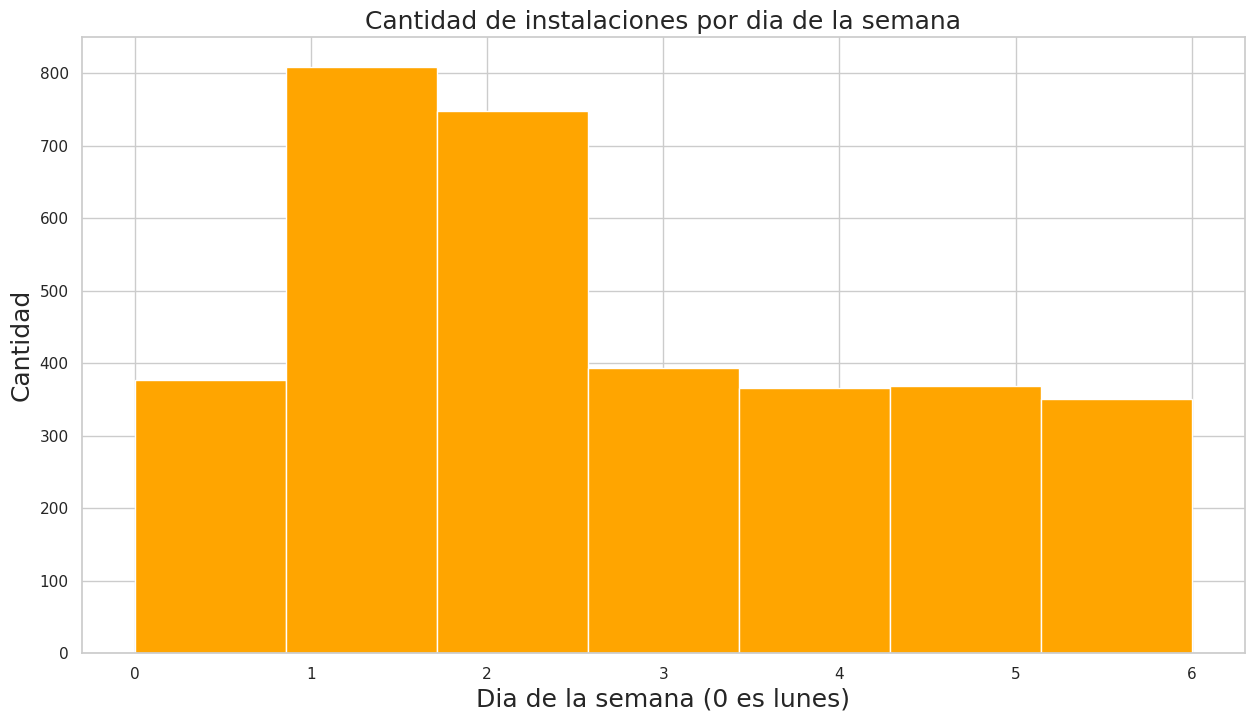

In [26]:
grafico_dia = installs['weekday'].plot.hist(bins = 7, color = 'orange', figsize = (15,8))
grafico_dia.set_title('Cantidad de instalaciones por dia de la semana', fontsize = 18)
grafico_dia.set_xlabel('Dia de la semana (0 es lunes)', fontsize = 18)
grafico_dia.set_ylabel('Cantidad', fontsize = 18)

Aparentemente los martes y miercoles hay un pico de instalaciones

## Correlacion entre cantidad de encuestas e installs por device

Para ver esta correlacion voy a mantener todos los devices que participaron a las subastas, tanto si instalaron como si no. Buscare la cantidad de instalaciones en funcion de la cantidad de subastas a las que "asistio". En realidad, no me interesa la cantidad de instalaciones per se. Me interesa si instalo o no.

In [9]:
auctions = pd.read_csv('datos/auctions.csv.gzip', compression = 'gzip')

In [10]:
id_usuarios = auctions.groupby('device_id').count()
id_usuarios['cantidad_subastas'] = id_usuarios['source_id']
id_usuarios.reset_index(inplace = True)
id_usuarios.drop(columns = ['auction_type_id','country','platform','ref_type_id', 'source_id','date'], inplace = True)


In [12]:
ref_hash_apariciones = installs.groupby('ref_hash').count()
ref_hash_apariciones['cantidad_instalaciones'] = ref_hash_apariciones['created']
ref_hash_apariciones.reset_index(inplace = True)
ref_hash_apariciones.drop(columns = ['created','application_id','ref_type','click_hash', 'attributed','implicit','device_countrycode','device_brand','device_model','session_user_agent','user_agent','event_uuid','kind','wifi','trans_id','ip_address','device_language','hour'], inplace = True)


In [13]:
full_join = pd.merge(id_usuarios,ref_hash_apariciones,left_on = 'device_id', right_on = 'ref_hash', how = 'left')
full_join = full_join.loc[full_join['cantidad_subastas'] < 500] #Los mayores de 500 son muy pocos (y dudosos).
full_join['cantidad_instalaciones'].fillna(0, inplace = True)# Si tienen NaN en la cantidad de instalaciones es porque participaron de subastas pero no instalaron
full_join.drop(columns = ['ref_hash'], inplace = True)
full_join_a_graficar = full_join.drop(columns = ['device_id'])


Text(0, 0.5, 'Cantidad de instalaciones')

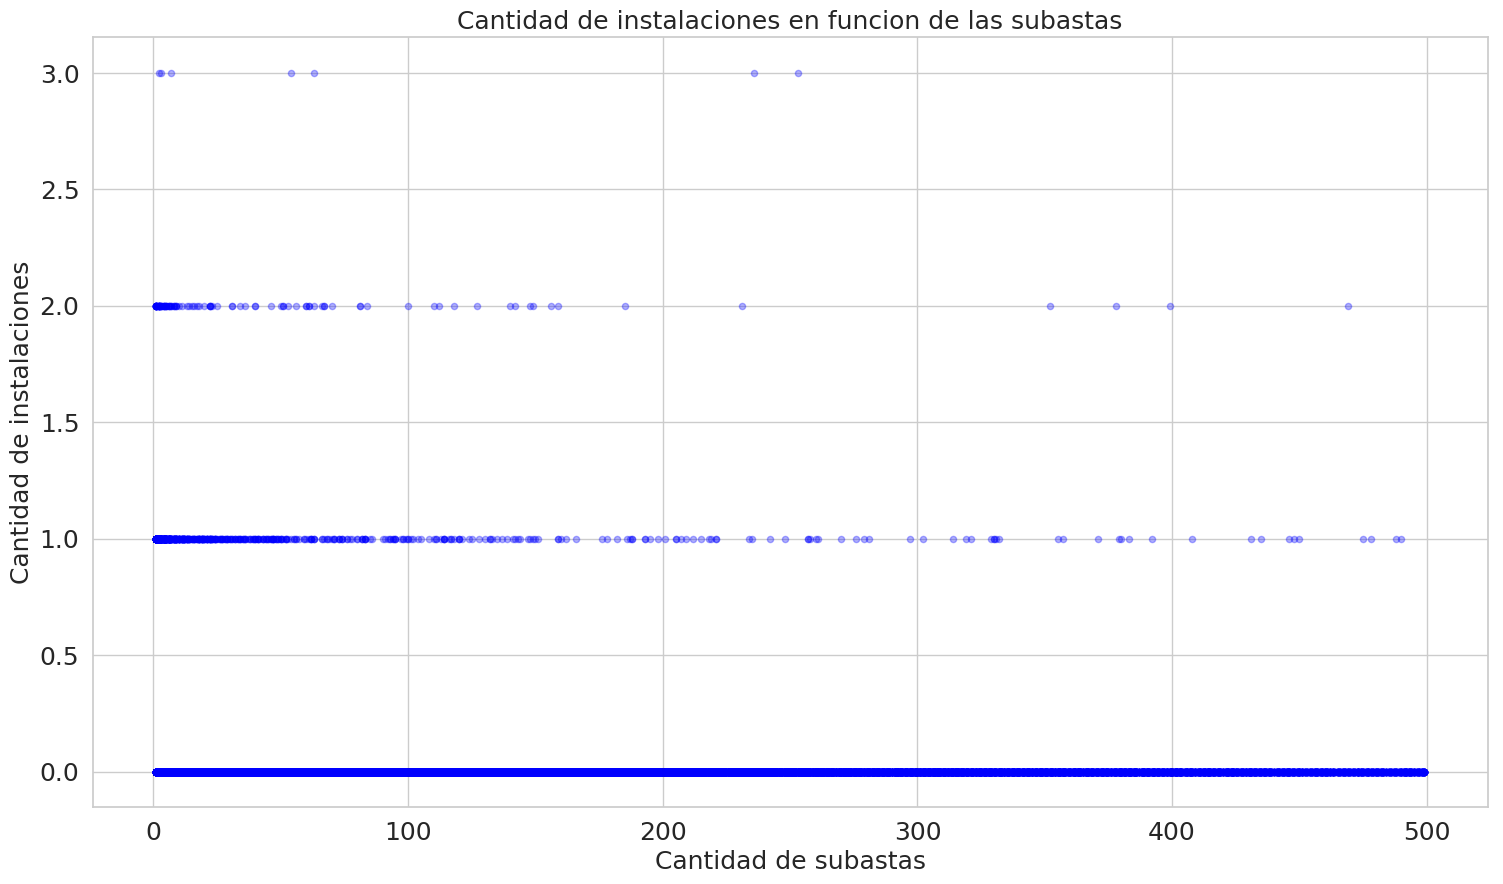

In [28]:
grafico = full_join_a_graficar.plot.scatter(x = 'cantidad_subastas', y = 'cantidad_instalaciones', alpha = 0.3, figsize = (18,10), fontsize=18, color = 'blue')
grafico.set_title("Cantidad de instalaciones en funcion de las subastas", fontsize=18)
grafico.set_xlabel("Cantidad de subastas",fontsize=18)
grafico.set_ylabel("Cantidad de instalaciones", fontsize=18)

Podemos ver que no hay correlacion entre la cantidad de instalaciones con la cantidad de subastas participadas. Ya de entrada tengo muchisimos casos donde se participa de subastas y no se produce ninguna instalacion, incluso en zonas de muchas subastas. Ademas se ve que en los casos donde se produjo una instalacion, hay mayor densidad en la zona de pocas subastas. 